In [1]:
from preprocess import preprocess_data_flat, get_isa_responses
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.style.use("seaborn-v0_8-white")
sns.set_style("white")

In [ ]:
df_final = [preprocess_data_flat(x, 30, False) for x in ["1", "2"]]
x_final, y_final = [pd.concat([x[i] for x in df_final], ignore_index=True) for i in range(2)]
df = x_final.join(y_final)
df_means = df.iloc[:, np.r_[0:56, -1]]

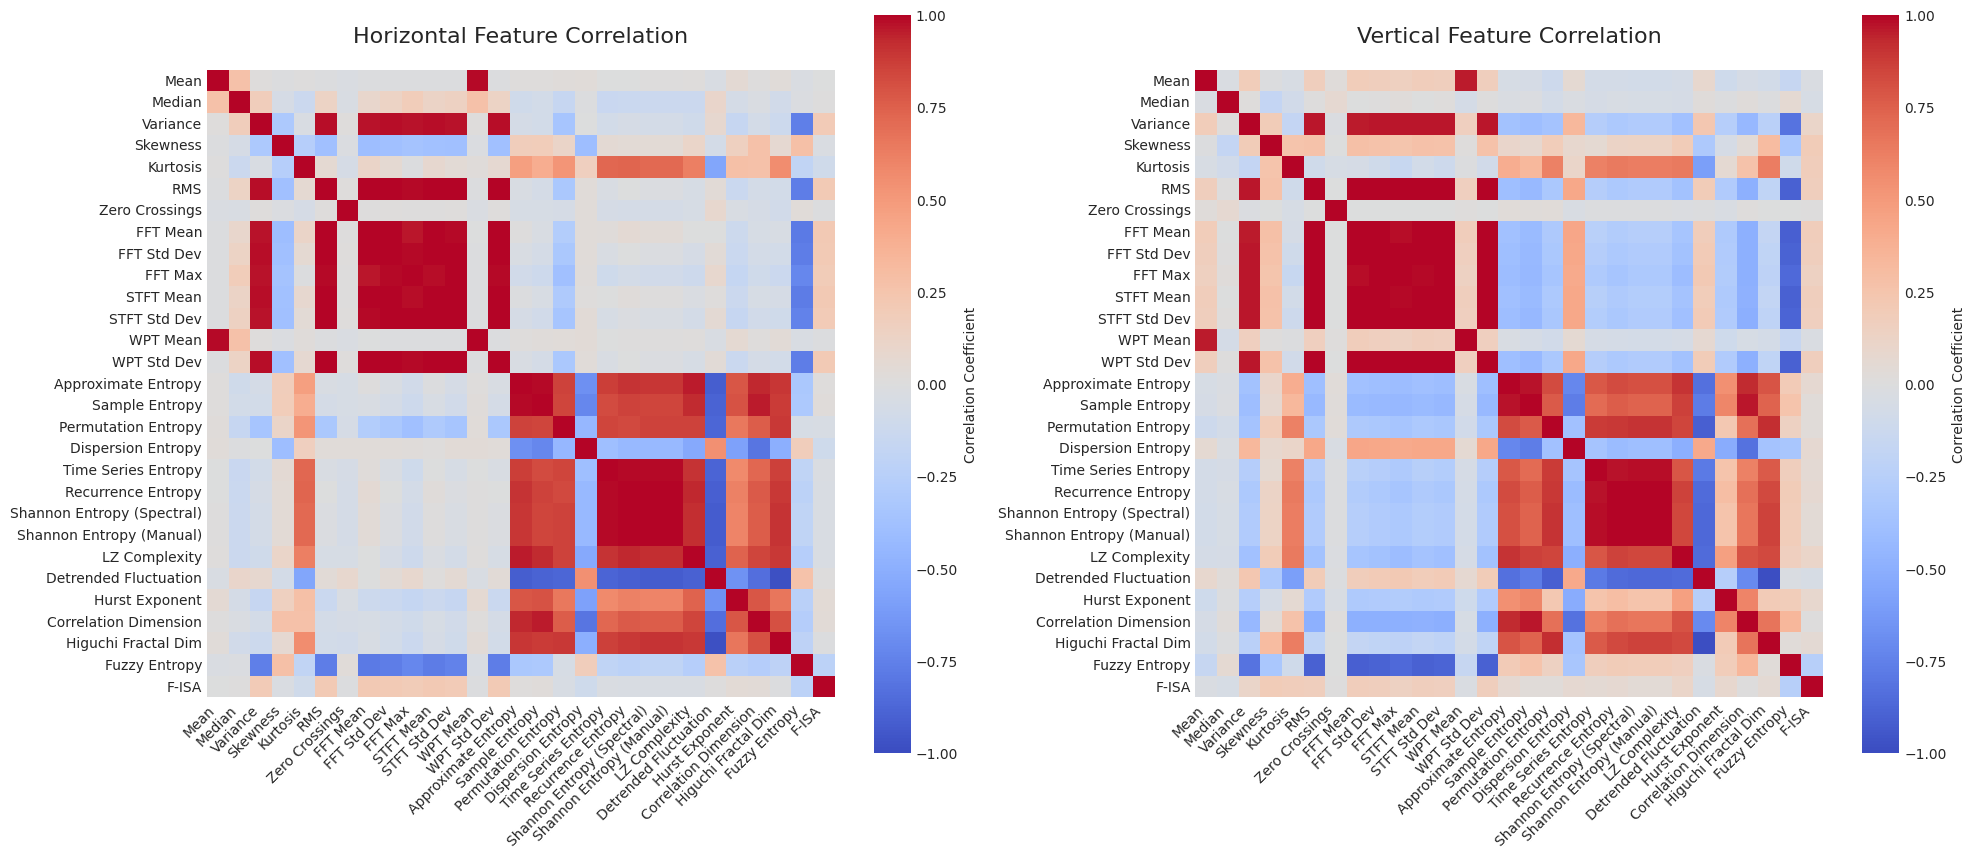

In [4]:
def clean_column_names(columns, add_suffix=False):
    name_mapping = {
        'Mean': 'Mean',
        'Median': 'Median',
        'Variance': 'Variance',
        'Skewness': 'Skewness',
        'Kurtosis': 'Kurtosis',
        'RMS': 'RMS',
        'ZeroCrossings': 'Zero Crossings',
        'FFT_Mean': 'FFT Mean',
        'FFT_Std': 'FFT Std Dev',
        'FFT_Max': 'FFT Max',
        'STFT_Mean': 'STFT Mean',
        'STFT_Std': 'STFT Std Dev',
        'WPT_Mean': 'WPT Mean',
        'WPT_Std': 'WPT Std Dev',
        'ApEn': 'Approximate Entropy',
        'SampEn': 'Sample Entropy',
        'PeEn': 'Permutation Entropy',
        'DispEn': 'Dispersion Entropy',
        'TsEn': 'Time Series Entropy',
        'ReEn': 'Recurrence Entropy',
        'ShEn_spectral': 'Shannon Entropy (Spectral)',
        'ShEn_manual': 'Shannon Entropy (Manual)',
        'LZC': 'LZ Complexity',
        'DFA': 'Detrended Fluctuation',
        'HuEx': 'Hurst Exponent',
        'CD': 'Correlation Dimension',
        'HFD': 'Higuchi Fractal Dim',
        'FuzEn': 'Fuzzy Entropy',
        'F_ISA': 'F-ISA'
    }
    
    cleaned_names = []
    for col in columns:
        if col == 'F_ISA':
            cleaned_names.append('F-ISA')
            continue
            
        parts = col.split('_')
        direction = None
        
        if 'horizontal' in col or 'vertical' in col:
            direction_idx = next(i for i, part in enumerate(parts) if part in ['horizontal', 'vertical'])
            direction = parts[direction_idx].capitalize()
            feature_parts = parts[:direction_idx]
            feature = '_'.join(feature_parts)
        else:
            feature = col
        
        clean_name = name_mapping.get(feature, feature)
        
        if add_suffix and direction:
            clean_name = f"{clean_name} ({direction})"
            
        cleaned_names.append(clean_name)
    
    return cleaned_names

horizontal_cols = [col for col in df_means.columns if 'horizontal' in col]
vertical_cols = [col for col in df_means.columns if 'vertical' in col]
f_isa_col = ['F_ISA'] if 'F_ISA' in df_means.columns else []

df_horizontal_with_fisa = df_means[horizontal_cols + f_isa_col].copy()
df_vertical_with_fisa = df_means[vertical_cols + f_isa_col].copy()

df_horizontal_with_fisa.columns = clean_column_names(horizontal_cols + f_isa_col)
df_vertical_with_fisa.columns = clean_column_names(vertical_cols + f_isa_col)

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
corr_horizontal = df_horizontal_with_fisa.corr()
sns.heatmap(corr_horizontal, 
            cmap='coolwarm', 
            center=0, 
            vmin=-1, vmax=1,
            square=True,
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
            ax=ax1)
ax1.set_title('Horizontal Feature Correlation', fontsize=16, pad=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = fig.add_subplot(122)
corr_vertical = df_vertical_with_fisa.corr()
sns.heatmap(corr_vertical, 
            cmap='coolwarm', 
            center=0, 
            vmin=-1, vmax=1,
            square=True,
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
            ax=ax2)
ax2.set_title('Vertical Feature Correlation', fontsize=16, pad=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("figures/feature_correlation.png")

In [7]:
df_final

[(     Mean_horizontal_filtered_mean  Median_horizontal_filtered_mean  \
  0                        -0.000342                        -0.001793   
  1                         0.000251                         0.001733   
  2                        -0.000446                        -0.002469   
  3                         0.000347                        -0.002470   
  4                        -0.001578                        -0.008045   
  ..                             ...                              ...   
  226                      -0.002485                        -0.026493   
  227                       0.002504                        -0.004665   
  228                      -0.003875                         0.007453   
  229                       0.003073                        -0.002776   
  230                       0.004000                        -0.000258   
  
       Variance_horizontal_filtered_mean  Skewness_horizontal_filtered_mean  \
  0                             0.002582  

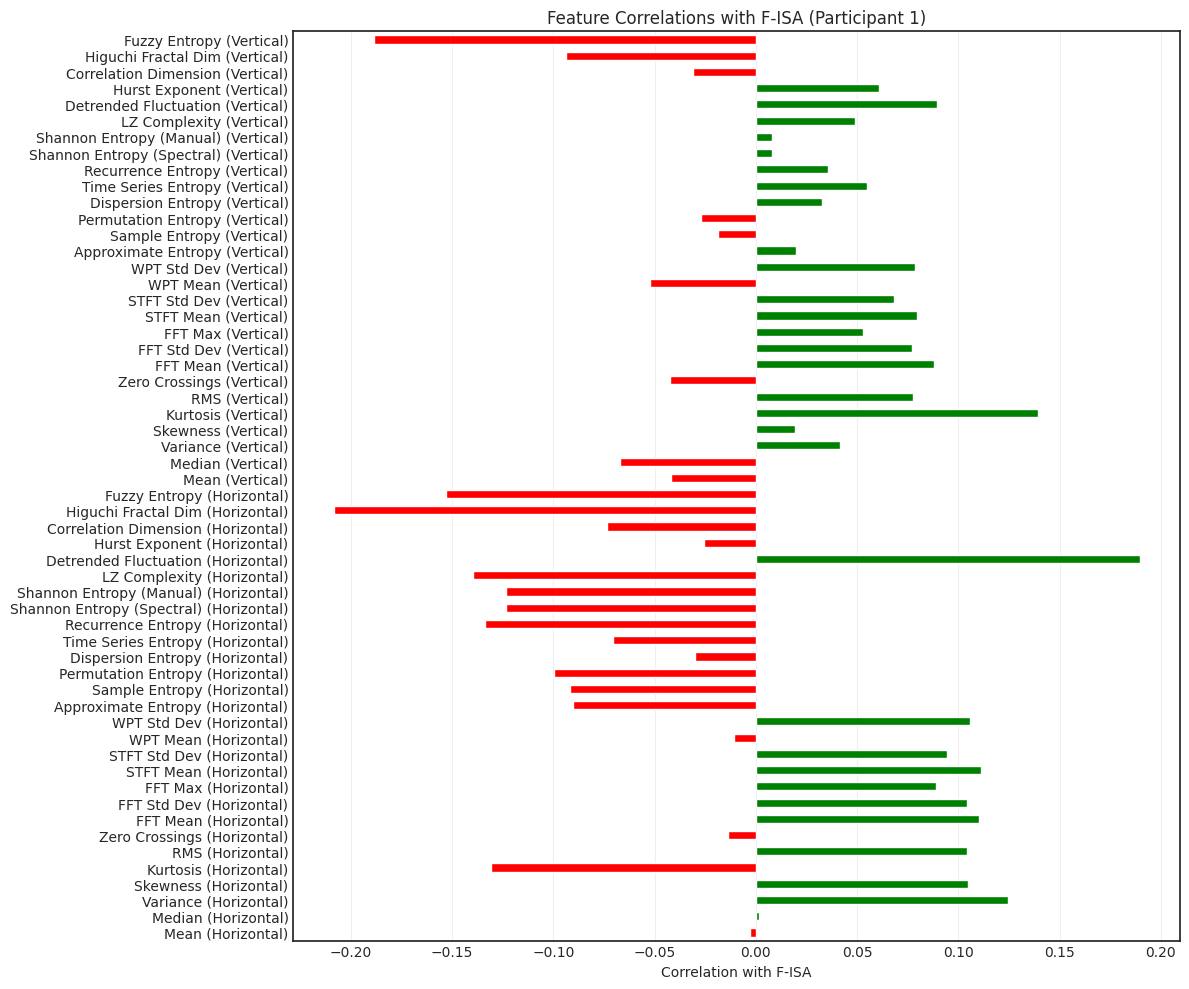

In [16]:
all_features = df_means.columns.tolist()
all_features_clean = clean_column_names(all_features, True)
df_all_clean = df_means.copy()
df_all_clean.columns = all_features_clean

f_isa_correlations = df_all_clean.corr()['F-ISA']
f_isa_correlations = f_isa_correlations.drop('F-ISA')

plt.figure(figsize=(12, 10))
f_isa_correlations.plot(kind='barh', color=['red' if x < 0 else 'green' for x in f_isa_correlations.values])
plt.xlabel('Correlation with F-ISA')
plt.title('Feature Correlations with F-ISA (Participant 1)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


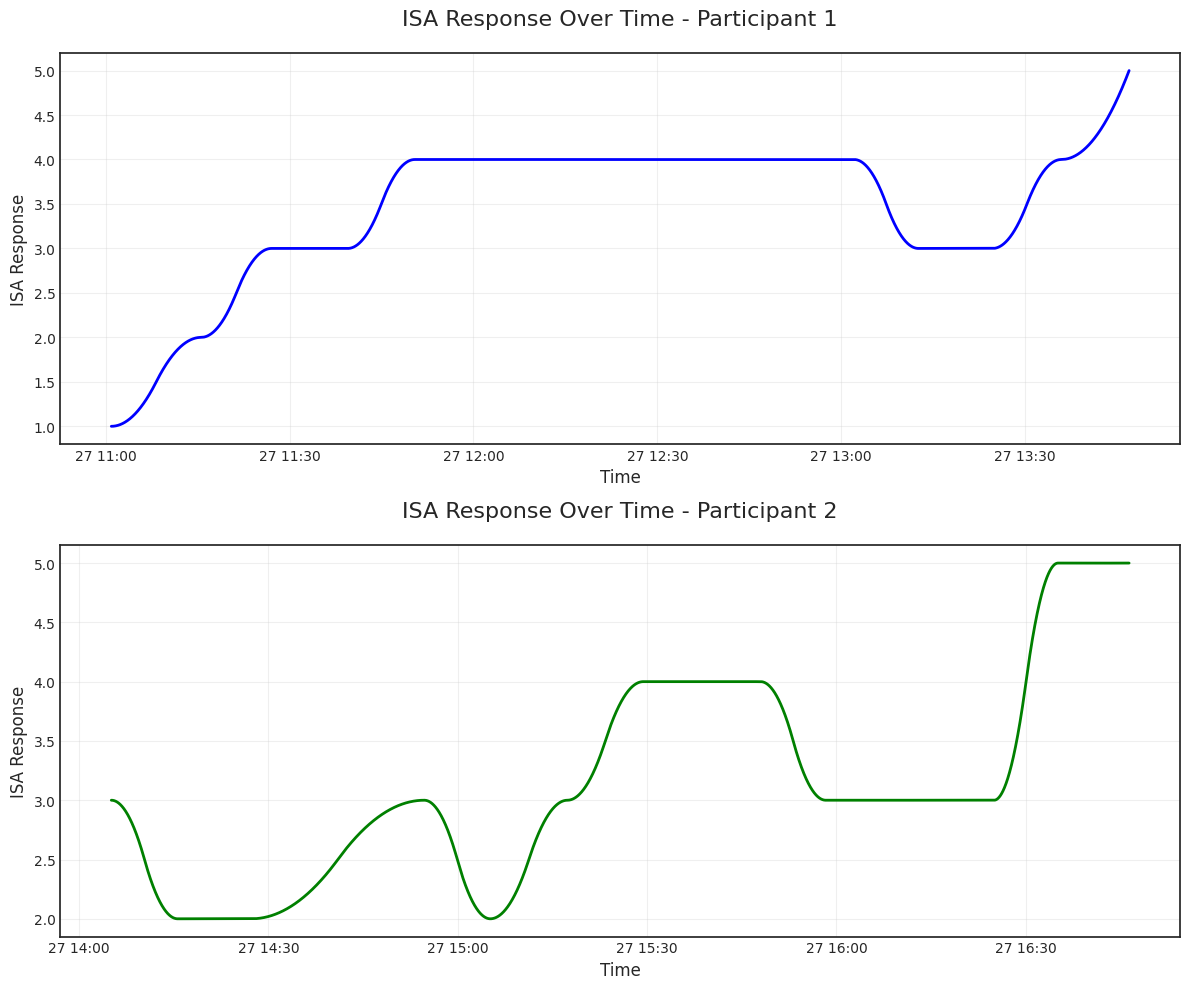

In [9]:
df_isa = [get_isa_responses(pd.read_parquet(f"data/{x}_pavlovia_raw_data.parquet").set_index(
    "timestamp"
)) for x in ["1", "2"]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df_isa[0].index, df_isa[0].values, color='blue', linewidth=2)
ax1.set_title('ISA Response Over Time - Participant 1', fontsize=16, pad=20)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('ISA Response', fontsize=12)
ax1.grid(True, alpha=0.3)

ax2.plot(df_isa[1].index, df_isa[1].values, color='green', linewidth=2)
ax2.set_title('ISA Response Over Time - Participant 2', fontsize=16, pad=20)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('ISA Response', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/ISA_Over_Time.png")

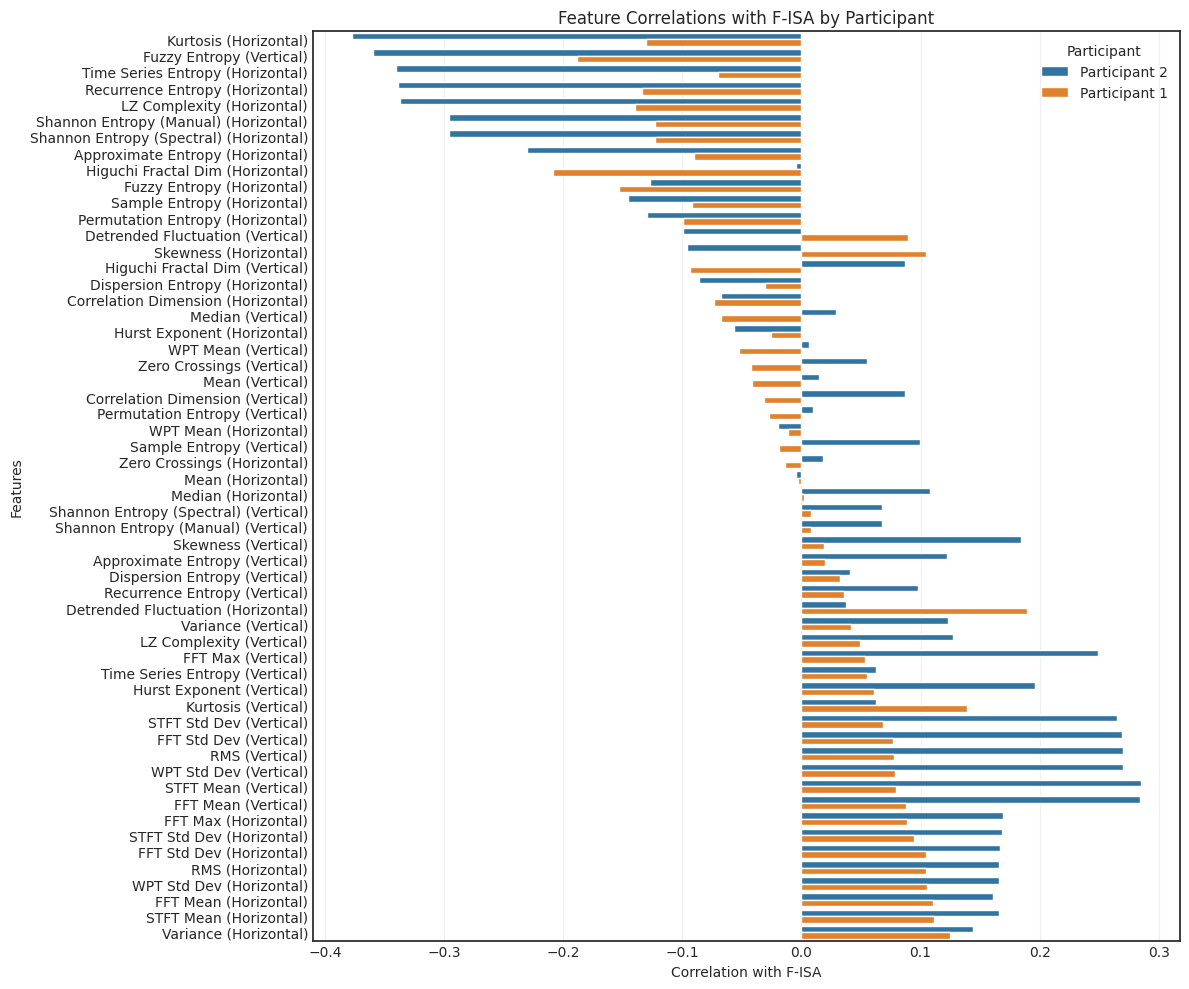

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract data for each participant from df_final
x_p1, y_p1 = df_final[0]  # Data for participant 1
x_p2, y_p2 = df_final[1]  # Data for participant 2

# Create DataFrames for each participant
df_p1 = x_p1.join(y_p1)
df_p2 = x_p2.join(y_p2)

# Extract the relevant columns for each participant (similar to df_means)
df_p1_means = df_p1.iloc[:, np.r_[0:56, -1]]
df_p2_means = df_p2.iloc[:, np.r_[0:56, -1]]

# Clean column names for each participant
features_p1 = df_p1_means.columns.tolist()
features_p2 = df_p2_means.columns.tolist()
features_clean_p1 = clean_column_names(features_p1, True)
features_clean_p2 = clean_column_names(features_p2, True)
df_p1_clean = df_p1_means.copy()
df_p2_clean = df_p2_means.copy()
df_p1_clean.columns = features_clean_p1
df_p2_clean.columns = features_clean_p2

# Calculate correlations with F-ISA for each participant
corr_p1 = df_p1_clean.corr()['F-ISA'].drop('F-ISA')
corr_p2 = df_p2_clean.corr()['F-ISA'].drop('F-ISA')

# Create a DataFrame to hold both sets of correlations
combined_corr = pd.DataFrame({
    'Participant 1': corr_p1,
    'Participant 2': corr_p2
})

# Reshape for seaborn (convert to long format)
combined_corr_long = combined_corr.reset_index().melt(
    id_vars='index', 
    var_name='Participant', 
    value_name='Correlation'
).

# Create the grouped bar chart using seaborn
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Correlation', 
    y='index', 
    hue='Participant', 
    data=combined_corr_long
)

plt.xlabel('Correlation with F-ISA')
plt.ylabel('Features')
plt.title('Feature Correlations with F-ISA by Participant')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

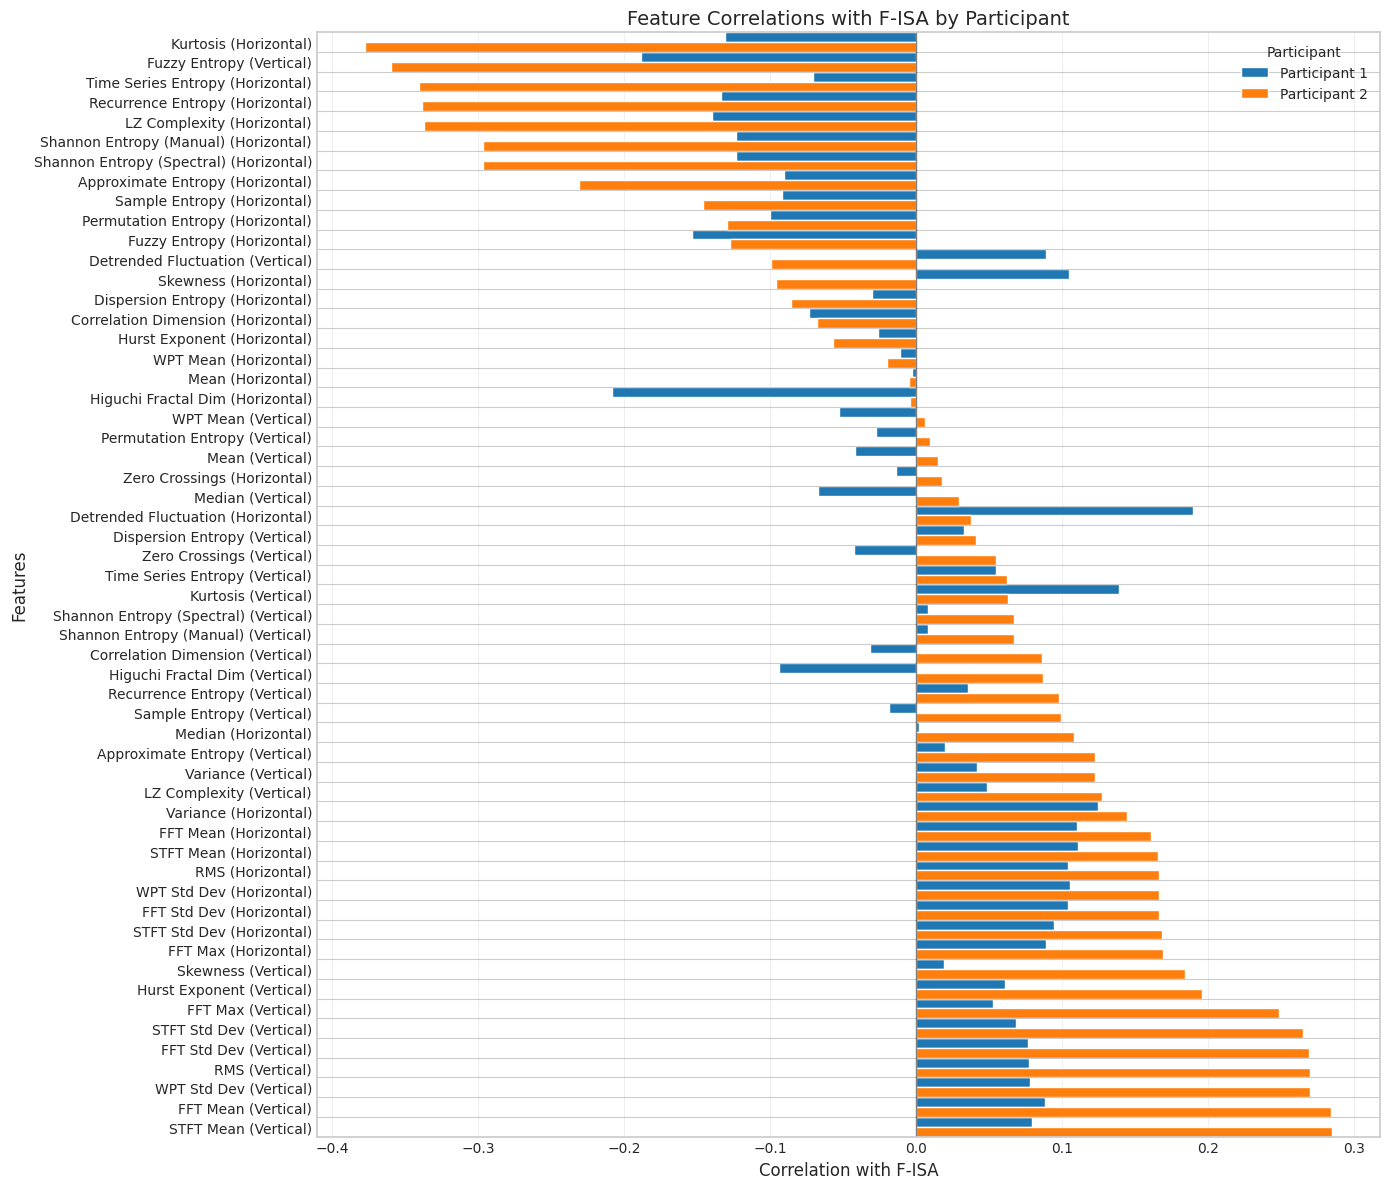

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract data for each participant from df_final
x_p1, y_p1 = df_final[0]  # Data for participant 1
x_p2, y_p2 = df_final[1]  # Data for participant 2

# Create DataFrames for each participant
df_p1 = x_p1.join(y_p1)
df_p2 = x_p2.join(y_p2)

# Extract the relevant columns for each participant (similar to df_means)
df_p1_means = df_p1.iloc[:, np.r_[0:56, -1]]
df_p2_means = df_p2.iloc[:, np.r_[0:56, -1]]

# Clean column names for each participant
features_p1 = df_p1_means.columns.tolist()
features_p2 = df_p2_means.columns.tolist()
features_clean_p1 = clean_column_names(features_p1, True)
features_clean_p2 = clean_column_names(features_p2, True)
df_p1_clean = df_p1_means.copy()
df_p2_clean = df_p2_means.copy()
df_p1_clean.columns = features_clean_p1
df_p2_clean.columns = features_clean_p2

# Calculate correlations with F-ISA for each participant
corr_p1 = df_p1_clean.corr()['F-ISA'].drop('F-ISA')
corr_p2 = df_p2_clean.corr()['F-ISA'].drop('F-ISA')

# Create a DataFrame to hold both sets of correlations
combined_corr = pd.DataFrame({
    'Participant 1': corr_p1,
    'Participant 2': corr_p2
})

# Sort the DataFrame by Participant 2's correlation values in ascending order
combined_corr = combined_corr.sort_values(by='Participant 2', ascending=True)

# Reshape for seaborn (convert to long format)
combined_corr_long = combined_corr.reset_index().melt(
    id_vars='index', 
    var_name='Participant', 
    value_name='Correlation'
)

# Create the grouped bar chart using seaborn with custom parameters
plt.figure(figsize=(14, 12))

# Turn off automatic padding
sns.set_style("whitegrid")

# Create the grouped bar chart with minimal spacing
ax = sns.barplot(
    x='Correlation', 
    y='index', 
    hue='Participant', 
    data=combined_corr_long,
    saturation=1.0,  # Full color saturation
    width=1       # Width of bars (0.8 is nearly full width)
)

# Add horizontal separator lines between features
feature_names = combined_corr.index.tolist()
for i in range(1, len(feature_names)):
    # Calculate positions between features (accounting for the way Seaborn places bars)
    line_pos = i - 0.5
    plt.axhline(y=line_pos, color='black', linestyle='-', alpha=0.2, linewidth=0.8)

# Add a vertical line at x=0 to show positive/negative correlation boundary
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1.0)

# Customize the appearance
plt.xlabel('Correlation with F-ISA', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Correlations with F-ISA by Participant', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Show the plot
plt.savefig("figures/feature_corr_by_participant.png")

In [33]:
df_binary = df.copy().iloc[:, np.r_[0:56, -1]]
df_binary["F_ISA"] = df_binary["F_ISA"].map(lambda x: x > 3)

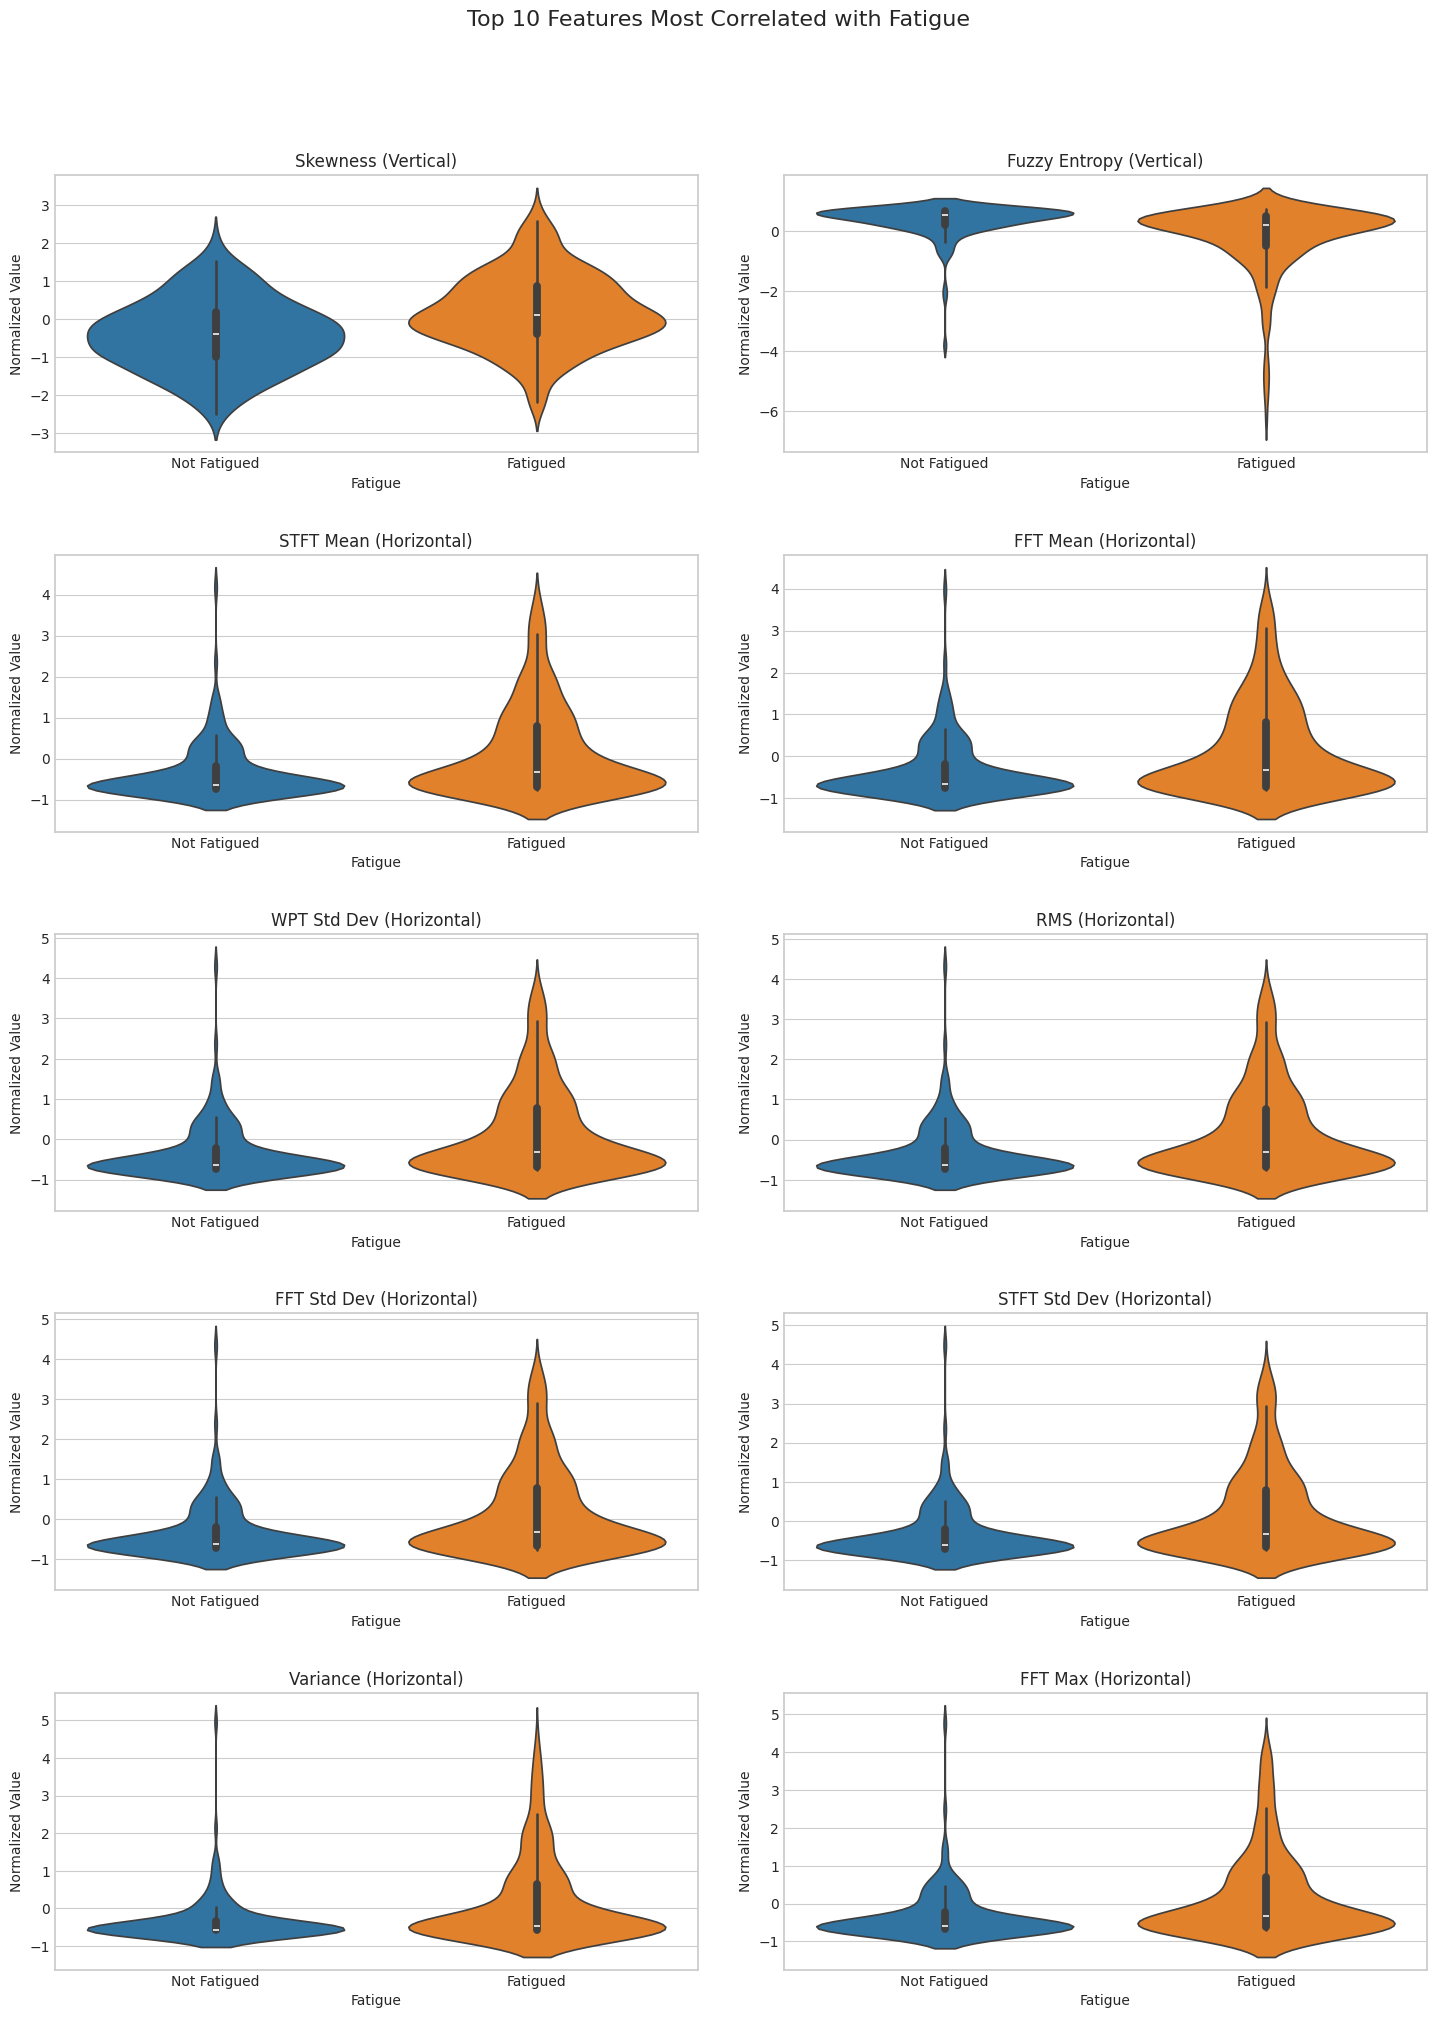

In [34]:
correlations = df_binary.corr()['F_ISA'].abs().sort_values(ascending=False)
correlations = correlations.drop('F_ISA')
top_10_features = correlations.head(10).index.tolist()

df_normalized = df_binary.copy()
scaler = StandardScaler()
df_normalized[top_10_features] = scaler.fit_transform(df_binary[top_10_features])

clean_names = clean_column_names(top_10_features, add_suffix=True)

n_features = len(top_10_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(15, 4 * n_rows))

for i, (col, clean_name) in enumerate(zip(top_10_features, clean_names)):
    plt.subplot(n_rows, n_cols, i + 1)
    
    sns.violinplot(x='F_ISA', y=col, data=df_normalized, hue='F_ISA', legend=False)
    
    plt.title(clean_name, fontsize=12)
    plt.xlabel('Fatigue')
    plt.ylabel('Normalized Value')
    plt.xticks([0, 1], ['Not Fatigued', 'Fatigued'])

plt.suptitle('Top 10 Features Most Correlated with Fatigue', fontsize=16, y=1.02)
plt.tight_layout(pad=3.0)
plt.savefig('top_10_fatigue_features_violin_plots.png', dpi=300, bbox_inches='tight')
plt.savefig("figures/violin.png")